In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPool2D
from keras.layers import Dense, add, BatchNormalization
from keras.layers import Activation, Flatten
from keras.datasets.cifar10 import load_data
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

## Loading dataset

In [2]:
(X_train, y_train), (X_test, y_test) = load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
print('X_train.shape\t:', X_train.shape)
print('y_train.shape\t:', y_train.shape)
print('X_test.shape\t:', X_test.shape)
print('y_test.shape\t:', y_test.shape)

X_train.shape	: (50000, 32, 32, 3)
y_train.shape	: (50000, 1)
X_test.shape	: (10000, 32, 32, 3)
y_test.shape	: (10000, 1)


In [4]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

## Displaying several images in the dataset

In [5]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

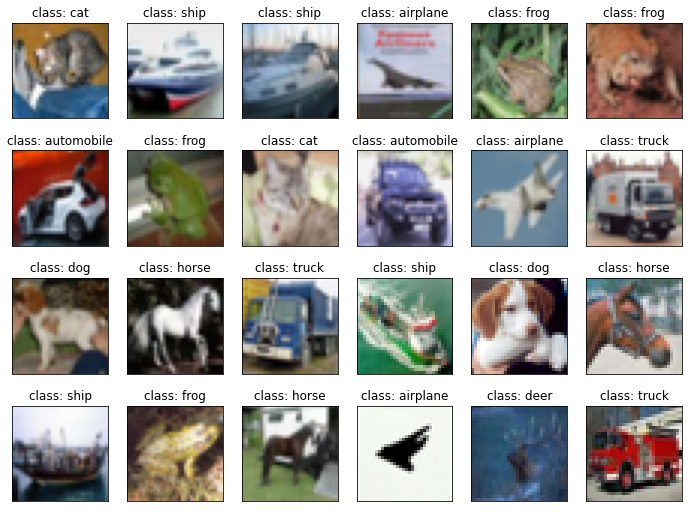

In [6]:
fig, axes = plt.subplots(ncols=6, nrows=4, figsize=(12, 9))
index = 0
for i in range(4):
    for j in range(6):
        axes[i,j].set_title('class: {}'.\
                            format(labels[y_test[index][0]]))
        axes[i,j].imshow(X_test[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## Image preprocessing

In [7]:
X_train = X_train / 255
X_test = X_test / 255

## Converting label to one-hot

In [8]:
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_encoded = one_hot_encoder.fit_transform(y_train)
y_test_encoded = one_hot_encoder.transform(y_test)

In [9]:
y_train_encoded[:3]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

## Data augmentation

In [10]:
datagen = ImageDataGenerator(rotation_range=10, 
                             zoom_range=0.1, 
                             width_shift_range=0.1, 
                             height_shift_range=0.1, 
                             horizontal_flip=True)

datagen.fit(X_train)

## Creating the residual network

In [11]:
input_1 = Input(shape=(32,32,3))

main = Conv2D(64, (3,3), padding='same', 
              activation='relu')(input_1)
main = Conv2D(128, (3,3), padding='same', 
              activation='relu')(main)

main = BatchNormalization()(main)
main = MaxPool2D((2,2))(main)
main = BatchNormalization()(main)

main = Conv2D(256, (3,3), padding='same', 
              activation='relu')(main)
main = Conv2D(256, (3,3), padding='same', 
              activation='relu')(main)

main = BatchNormalization()(main)
main = MaxPool2D((2,2))(main)
main = BatchNormalization()(main)

In [12]:
secondary = Conv2D(256, (3,3), padding='same', 
                activation='relu')(input_1)
secondary = BatchNormalization()(secondary)
secondary = MaxPool2D((4,4))(secondary)
secondary = BatchNormalization()(secondary)

In [13]:
merge = add([main, secondary])
merge = BatchNormalization()(merge)
merge = Activation('relu')(merge)
merge = BatchNormalization()(merge)
merge = MaxPool2D((2,2))(merge)

In [14]:
output = Flatten()(merge)
output = Dense(10, activation='softmax')(output)

In [15]:
resnet = Model(input_1, output)

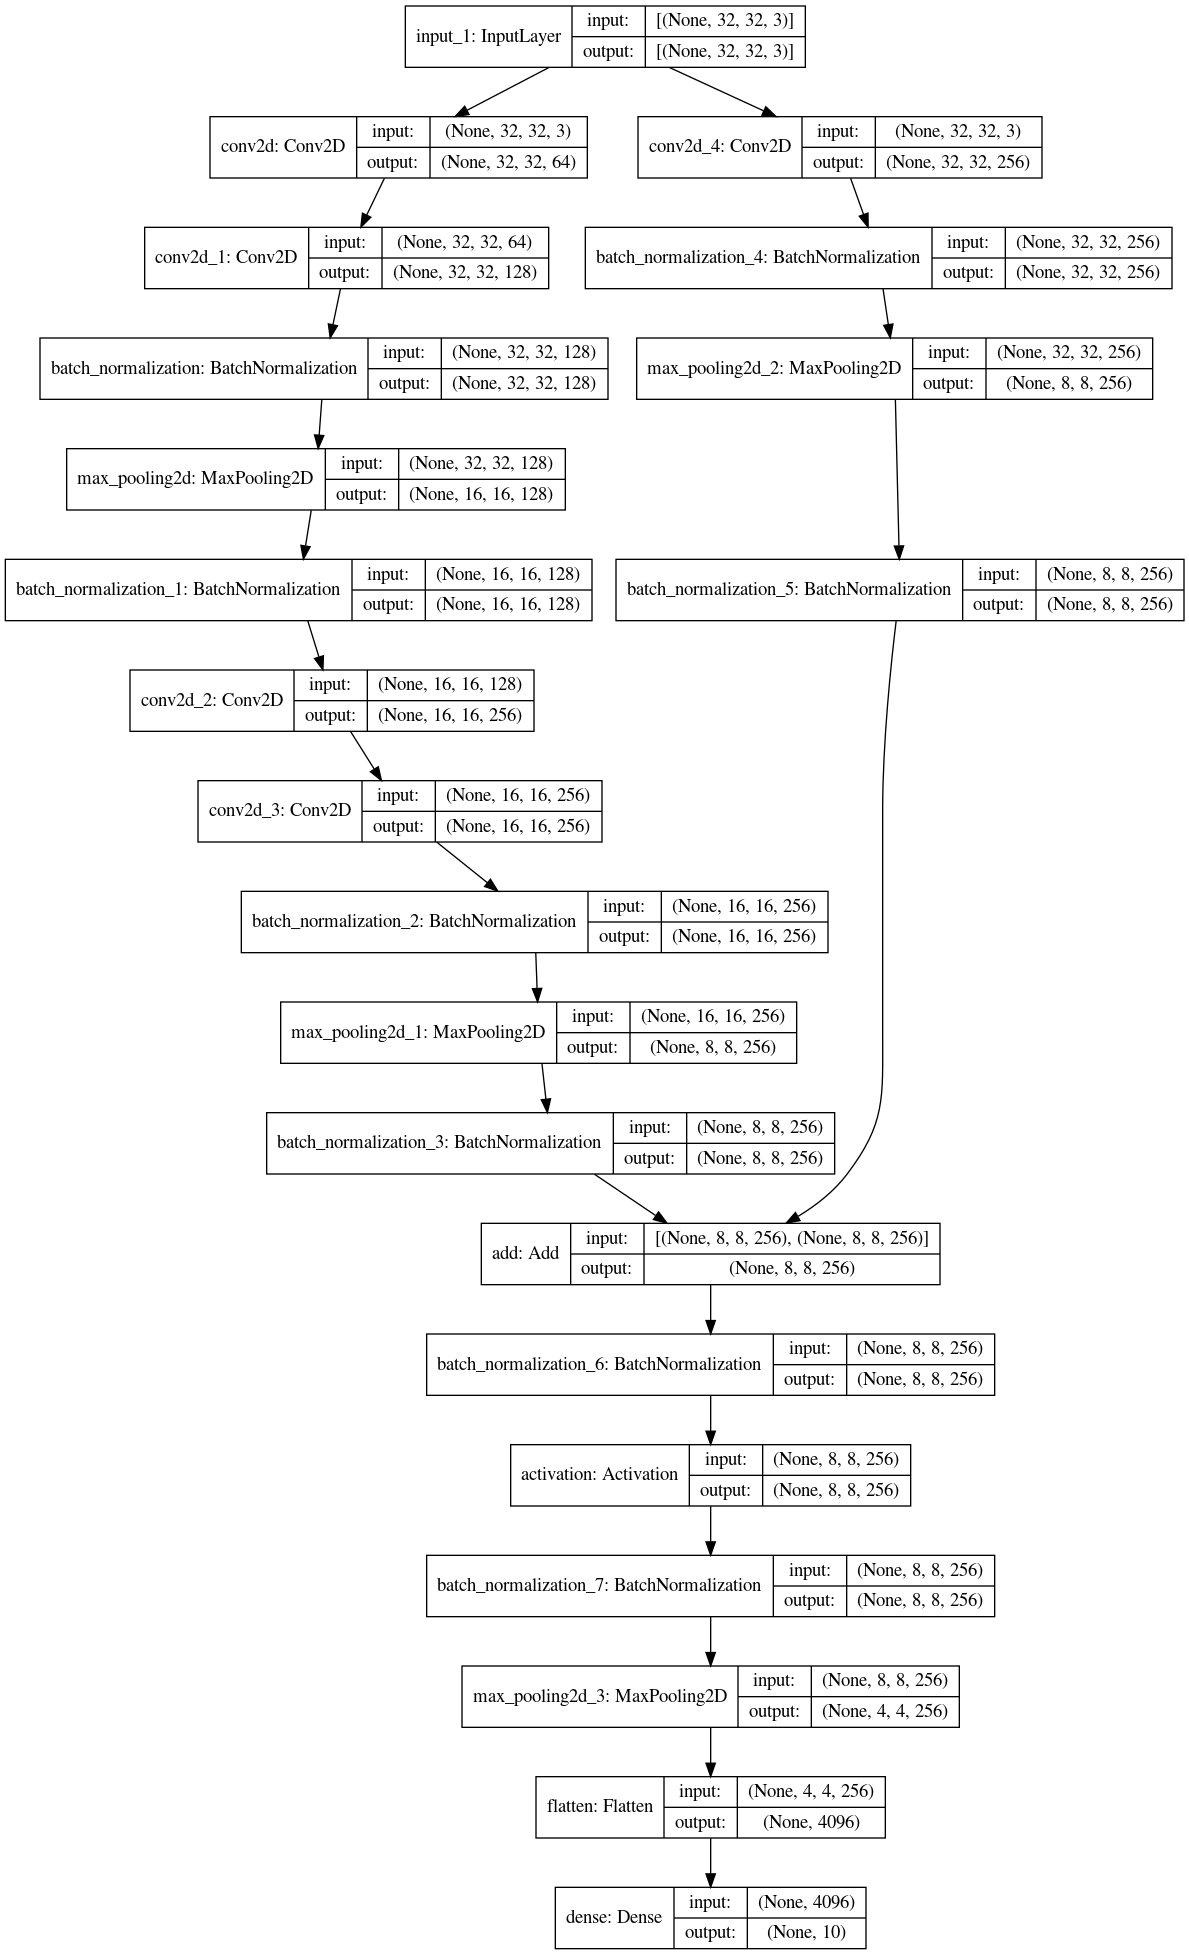

In [16]:
plot_model(resnet, show_shapes=True, 
           to_file='ResNet based model.png')

In [17]:
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  73856       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 128)  512         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [18]:
opt = Adam(learning_rate=1e-3, decay=1e-5)

resnet.compile(loss='categorical_crossentropy', 
               optimizer=opt, 
               metrics=['acc'])

## Model checkpoint

In [19]:
checkpoint = ModelCheckpoint('resnet.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True)

## Train the neural network

In [20]:
history = resnet.fit(datagen.flow(X_train, 
                                  y_train_encoded, 
                                  batch_size=64), 
                     epochs=60, 
                     validation_data=(X_test, 
                                      y_test_encoded), 
                     callbacks=[checkpoint])

Epoch 1/60
782/782 [==============================] - 34s 39ms/step - loss: 1.9393 - acc: 0.4102 - val_loss: 1.8468 - val_acc: 0.5021

Epoch 00001: val_acc improved from -inf to 0.50210, saving model to resnet.h5
Epoch 2/60
782/782 [==============================] - 30s 38ms/step - loss: 1.2431 - acc: 0.5841 - val_loss: 1.3576 - val_acc: 0.6104

Epoch 00002: val_acc improved from 0.50210 to 0.61040, saving model to resnet.h5
Epoch 3/60
782/782 [==============================] - 30s 38ms/step - loss: 1.0120 - acc: 0.6598 - val_loss: 1.1379 - val_acc: 0.6476

Epoch 00003: val_acc improved from 0.61040 to 0.64760, saving model to resnet.h5
Epoch 4/60
782/782 [==============================] - 30s 38ms/step - loss: 0.8799 - acc: 0.7012 - val_loss: 1.0059 - val_acc: 0.6972

Epoch 00004: val_acc improved from 0.64760 to 0.69720, saving model to resnet.h5
Epoch 5/60
782/782 [==============================] - 30s 38ms/step - loss: 0.7937 - acc: 0.7323 - val_loss: 0.8398 - val_acc: 0.7338

Epoc

## Load the resnet.h5

In [28]:
model = load_model('resnet.h5')

In [29]:
predictions = model.predict(X_test)
predictions

array([[9.68619247e-08, 1.88448701e-06, 1.37004250e-07, ...,
        2.11968693e-10, 2.02376935e-10, 3.49972407e-09],
       [7.02026326e-10, 9.78122216e-07, 4.87543743e-20, ...,
        1.13974876e-17, 9.99999046e-01, 5.44936190e-15],
       [1.46232040e-07, 3.09509202e-03, 6.78953394e-10, ...,
        2.25317348e-10, 9.96904671e-01, 9.57100852e-08],
       ...,
       [4.19765828e-12, 1.67221746e-13, 2.65789768e-05, ...,
        2.83952977e-05, 7.47004819e-11, 6.53670562e-10],
       [1.51759133e-10, 1.00000000e+00, 3.64583674e-09, ...,
        5.14103191e-13, 1.27726241e-14, 5.37391041e-13],
       [4.15303778e-14, 8.68034984e-12, 1.17237652e-11, ...,
        1.00000000e+00, 6.04567172e-16, 8.88143096e-17]], dtype=float32)

In [30]:
argmaxed = np.argmax(predictions, axis=1)
argmaxed

array([3, 8, 8, ..., 5, 1, 7])

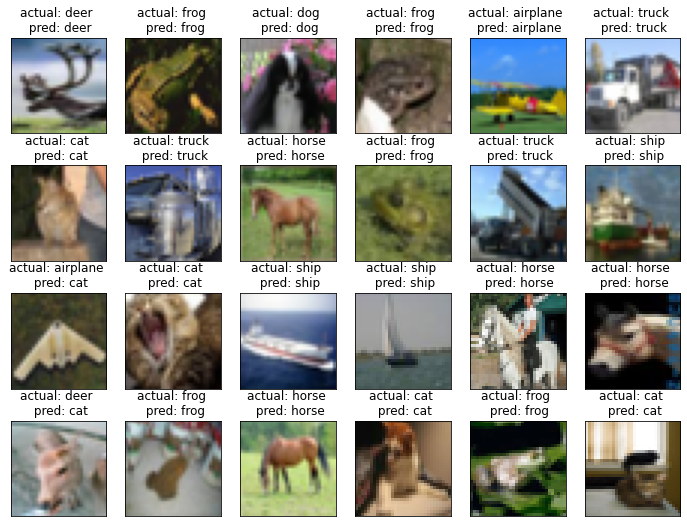

In [32]:
fig, axes = plt.subplots(ncols=6, nrows=4, figsize=(12, 9))
index = 40
for i in range(4):
    for j in range(6):
        axes[i,j].set_title('actual: {} \n pred: {}'.\
                            format(labels[y_test[index][0]], 
                                   labels[argmaxed[index]]))
        axes[i,j].imshow(X_test[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## Confusion matrix

In [26]:
cm = confusion_matrix(y_test, argmaxed)

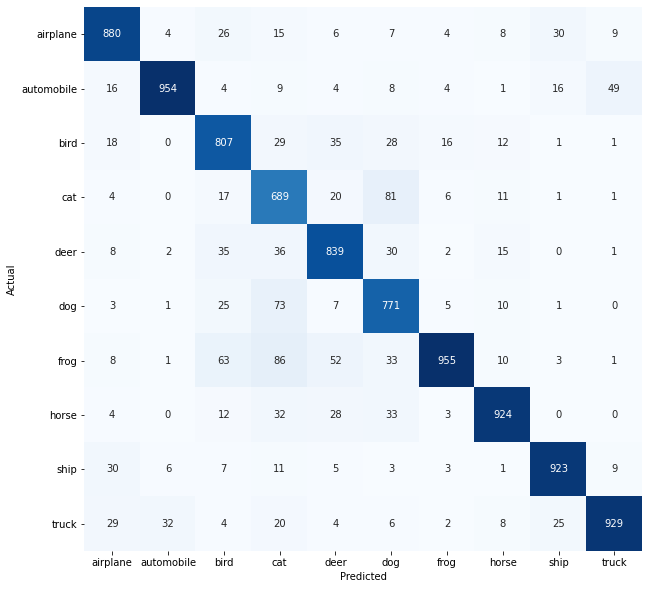

In [27]:
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', 
            cmap=plt.cm.Blues, 
            xticklabels=labels, yticklabels=labels, 
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()